In [24]:
import numpy as np
from numpy.linalg import cond
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import timeit
 

def vander(x, k=None):
    if k is None:
        k = len(x)
    m = len(x)
    V = np.ones((m, k))
    for j in range(1, k):
        V[:, j] = V[:, j-1] * x
    return V

def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x) # Square by default
    m = len(x)
    T = np.ones((m, n))
    if n > 1:
        T[:, 1] = x
    for k in range(2, n):
        T[:, k] = 2 * x * T[:, k-1] - T[:, k-2]
    return T

def chebyshev_regress_eval(x, xx, n):
    V = vander_chebyshev(x, n)
    return np.dot(vander_chebyshev(xx, n), np.linalg.pinv(V))

def runge(x):
    return 1 / (1 + 10*x**2)

def runge_noisy(x, sigma):
    return runge(x) + np.random.randn(*x.shape) * sigma

def CosRange(a, b, n):
    return (a + b)/2 + (b - a)/2 * np.cos(np.linspace(-np.pi, 0, n))



In [6]:
x = np.linspace(-1, 1, 500)
ytrain = runge_noisy(x, 0.2)
yfit = np.dot(chebyshev_regress_eval(x, x, 7), ytrain)

print(ytrain.shape, yfit.shape)


cond_values = [cond(vander_chebyshev(CosRange(-1, 1, n))) for n in range(2, 20)]



(500,) (500,)


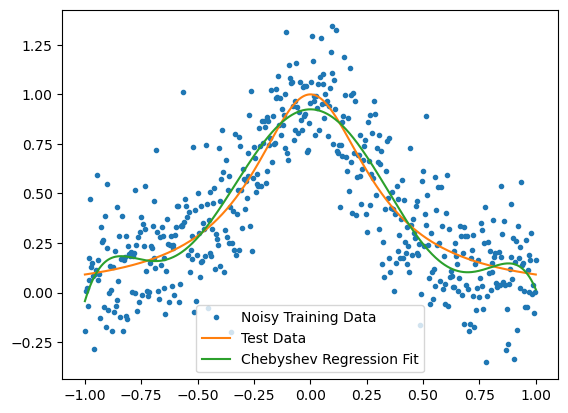

In [7]:
plt.plot(x, ytrain, '.', label='Noisy Training Data')
plt.plot(x, runge(x), label='Test Data')
plt.plot(x, yfit, label='Chebyshev Regression Fit')
plt.legend()
plt.show()


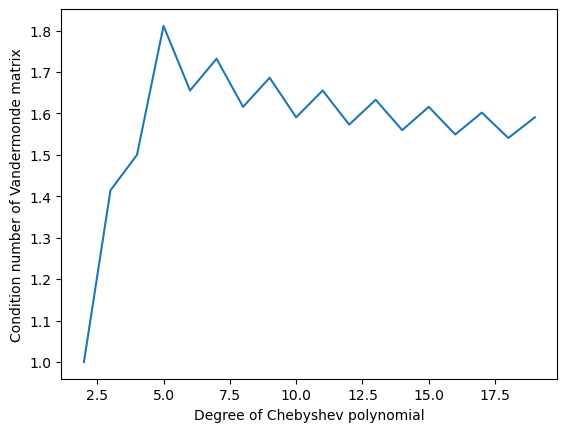

In [8]:
plt.plot(range(2, 20), cond_values)
plt.xlabel('Degree of Chebyshev polynomial')
plt.ylabel('Condition number of Vandermonde matrix')
plt.show()

## Scikit-Learn

0.012175642656632612


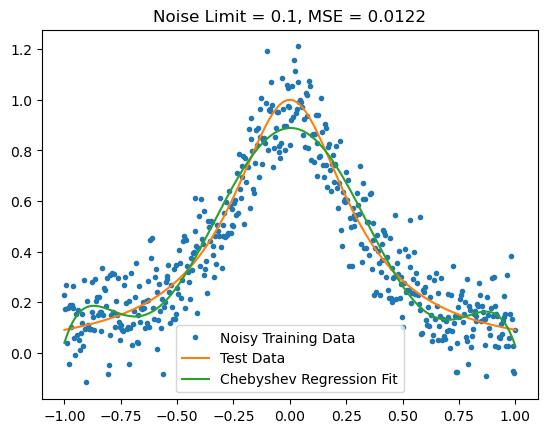

0.10233894718988425


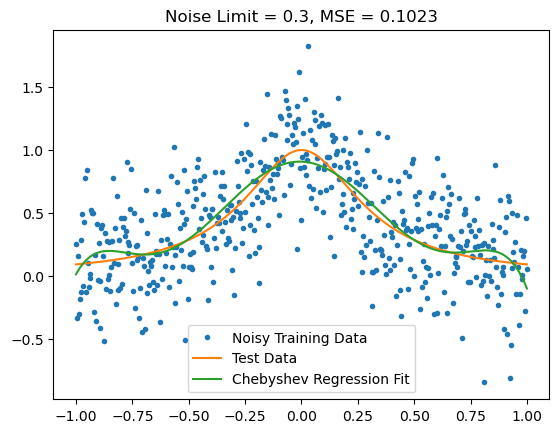

0.24911602633745236


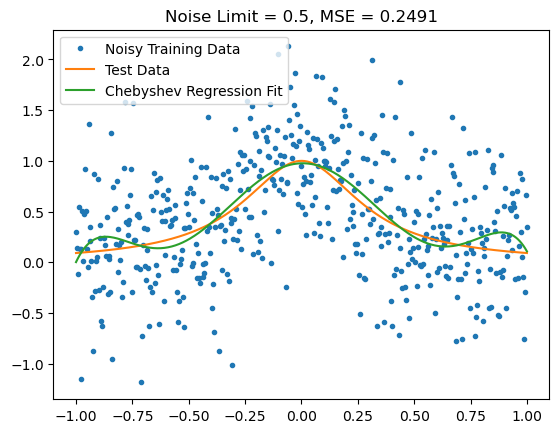

0.4739906498009749


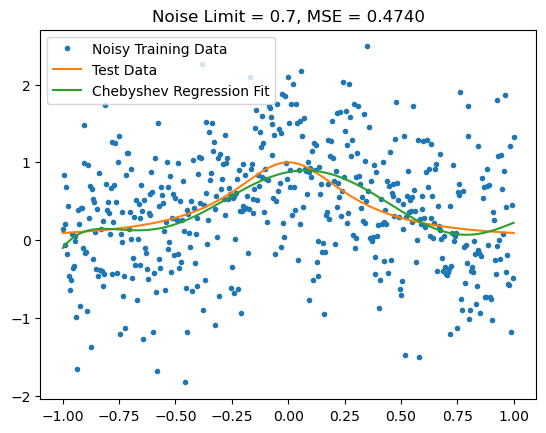

0.7606424266398966


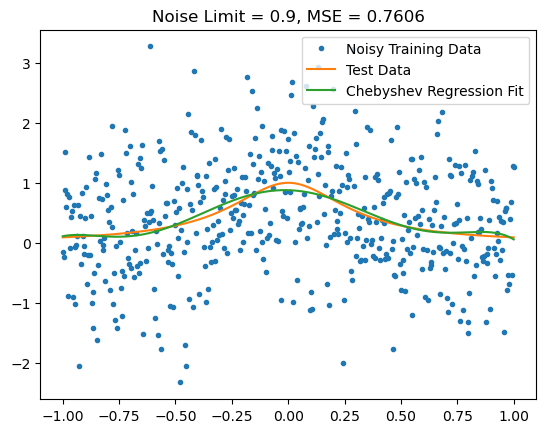

In [37]:

start = timeit.default_timer()

#Your statements here|

x = np.linspace(-1, 1, 500)
ytrain_ski = runge_noisy(x, 0.2)

# Construct the design matrix using Chebyshev basis functions
n = 7
poly = PolynomialFeatures(degree=n, include_bias=False)
X = poly.fit_transform(x[:, np.newaxis])
T = np.polynomial.chebyshev.chebvander(x, n-1)

# Solve for the coefficients using linear regression
reg = LinearRegression(fit_intercept=False)
reg.fit(T, ytrain_ski)

# Evaluate the model on the training set
yfit_ski = reg.predict(T)

# Evaluate the model on a finer grid of points`
xx = np.linspace(-1, 1, 1000)
Txx = np.polynomial.chebyshev.chebvander(xx, n-1)
yfitxx_ski = reg.predict(Txx)

#print(yfitxx_ski)

x = np.linspace(-1, 1, 500)
degrees = [2, 4, 6, 8, 10]  # different degrees of polynomial basis functions
noises = [0.05, 0.1, 0.2, 0.4, 0.6]  # different levels of noise in the data
mse_values = np.zeros((len(noises), len(degrees)))

# Loop over different noise levels and degrees of polynomial basis functions
for i, noise in enumerate(noises):
    ytrain = runge_noisy(x, noise)
    for j, degree in enumerate(degrees):
        # Construct the design matrix using polynomial basis functions
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X = poly.fit_transform(x[:, np.newaxis])

        # Solve for the coefficients using ridge regression
        reg = LinearRegression(fit_intercept=False)
        reg.fit(X, ytrain)

        # Evaluate the model on the training set
        yfit = reg.predict(X)

        # Compute mean squared error on the training set
        mse_values[i,j] = mean_squared_error(ytrain, yfit)

        
noise_limits = [0.1, 0.3, 0.5, 0.7, 0.9]
for sigma in noise_limits:

    # Generate noisy training data
    ytrain = runge_noisy(x, sigma)

    # Fit model with Chebyshev basis functions
    n = 7
    T = vander_chebyshev(x, n)
    reg = LinearRegression(fit_intercept=False)
    reg.fit(T, ytrain)

    # Evaluate model on training data
    yfit = reg.predict(T)

    # Evaluate model on test data
    Txx = vander_chebyshev(xx, n)
    yfitxx = reg.predict(Txx)

    # Compute MSE on training data
    mse = np.mean((ytrain - yfit)**2)
    print(mse)

    # Plot results
    fig, (ax1) = plt.subplots(nrows=1, ncols=1)

    ax1.plot(x, ytrain, '.', label='Noisy Training Data')
    ax1.plot(x, runge(x), label='Test Data')
    ax1.plot(x, yfit, label='Chebyshev Regression Fit')
    ax1.legend()
    ax1.set_title(f"Noise Limit = {sigma}, MSE = {mse:.4f}")
    

    
   
    plt.savefig("value" + str(sigma) + ".png")
    plt.show()
    

stop = timeit.default_timer()

In [36]:
print('Time: ', stop - start, 'seconds')

Time:  0.7640322090001064 seconds


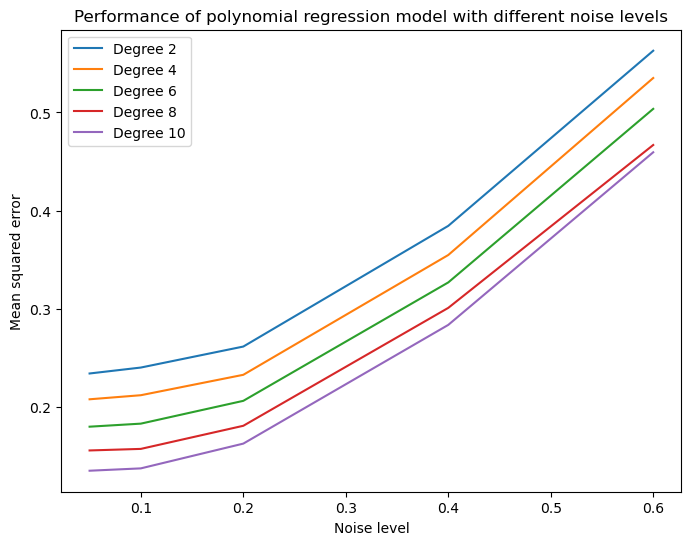

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
for j, degree in enumerate(degrees):
    ax.plot(noises, mse_values[:,j], label='Degree %d' % degree)
ax.set_xlabel('Noise level')
ax.set_ylabel('Mean squared error')
ax.set_title('Performance of polynomial regression model with different noise levels')
ax.legend()
plt.show()

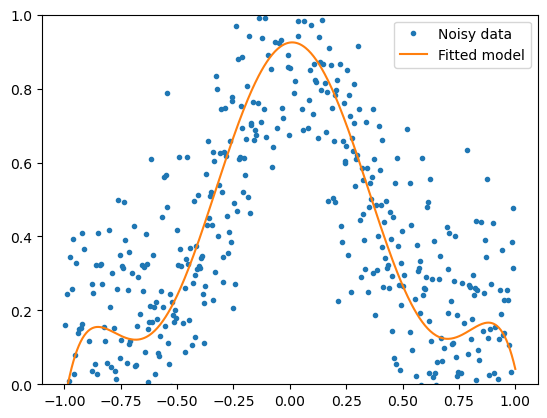

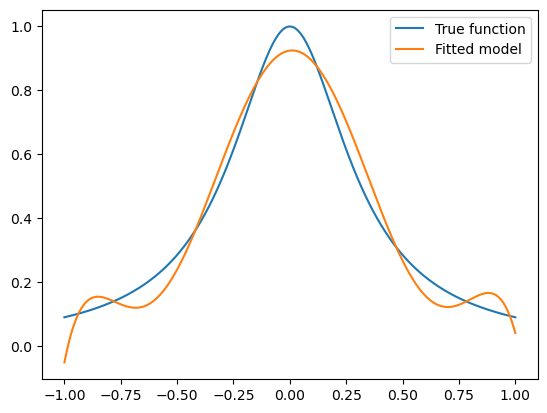

In [12]:
# Plot the noisy data and the fitted model
fig, ax = plt.subplots()
ax.plot(x, ytrain_ski, '.', label='Noisy data')
ax.plot(x, yfit_ski, label='Fitted model')
ax.set_ylim(0,1)
ax.legend()

# Plot the true function and the fitted model on a finer grid
fig, ax = plt.subplots()
ax.plot(xx, runge(xx), label='True function')
ax.plot(xx, yfitxx_ski, label='Fitted model')
ax.legend()






In [13]:
mse_python = mean_squared_error(ytrain_ski, yfit_ski)
print(mse_python)

0.038093196520112275
